### Non-spatial: Meuse

This file concerns non-spatial model of Meuse dataset.

In [1]:
# setwd("../Results")
options(stringsAsFactors = F)

--------
#### Load the helper functions:

- *hold_eval*: trainging/testing evaluation    

Please refer to the source file for details of these functions. 

In [2]:
source("lag_funcs.R")

In [3]:
# Data ----
library(ggplot2)
library(dplyr)
library(sf)
data("meuse", package = "sp")
# remove NA rows (3)
meuse.sf <- st_as_sf(meuse, coords = c("x", "y"), crs = 28992) %>% na.omit() %>% 
  st_transform(meuse, crs=4326)
rm(meuse)
meuse.sf <- select(meuse.sf, -c("cadmium","copper","lead", "dist.m"))



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



In [4]:
head(meuse.sf)

,zinc,elev,dist,om,ffreq,soil,lime,landuse,geometry
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<POINT [°]>
1,1022,7.909,0.00135803,13.6,1,1,1,Ah,POINT (5.758536 50.99156)
2,1141,6.983,0.01222430,14.0,1,1,1,Ah,POINT (5.757863 50.99109)
3,640,7.800,0.10302900,13.0,1,1,1,Ah,POINT (5.759855 50.99089)
4,257,7.655,0.19009400,8.0,1,2,0,Ga,POINT (5.761746 50.99041)
5,269,7.480,0.27709000,8.7,1,2,0,Ah,POINT (5.761863 50.98903)
6,281,7.791,0.36406700,7.8,1,2,0,Ga,POINT (5.76304 50.98839)


#### Spatial CV: train/test splitting

First, the traning and testing folds for spatial CV are generated. Here we use 5 outer folds and 3 inner folds. Package *mlr* requires a resample description object. Then the resampling instace is created based on the task defined.

Note: change the value of variable ***cvmethod*** to "CV" for nornal CV

In [5]:
# Spatial CV: train/test splitting ----

library(mlr)
outer_n <- 5
inner_n <- 3
cvmethod <- "SpCV" # Change to"CV" for normal CV

Loading required package: ParamHelpers

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).



In [6]:
set.seed(123) # Set seeds
# Resampling description (outer folds)
rdesc <- makeResampleDesc(cvmethod, iters = outer_n)
# Regression task definition
spatial.task <- makeRegrTask(data = st_drop_geometry(meuse.sf), target = "zinc", 
                             coordinates = as.data.frame(st_coordinates(meuse.sf)))
# Resampling instance (outer folds)
outer.rin <- makeResampleInstance(rdesc, task = spatial.task)
rm(rdesc, spatial.task)

# Generating inner folds
inner <- lapply(1:length(outer.rin$train.inds), function(i) {
  idx.train <- outer.rin$train.inds[[i]]
  idx.test <- outer.rin$test.inds[[i]]
  set.seed(123)
  rdesc <- makeResampleDesc(cvmethod, iters = inner_n)
  spatial.task <- makeRegrTask(data = st_drop_geometry(meuse.sf[idx.train,]), target = "zinc", 
                               coordinates = as.data.frame(st_coordinates(meuse.sf[idx.train,])))
  inner.rin <- makeResampleInstance(rdesc, task = spatial.task)
  list(train.inds = inner.rin$train.inds, test.inds = inner.rin$test.inds)
})

Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Empty factor levels were dropped for columns: landuse”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Empty factor levels were dropped for columns: landuse”
Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Empty factor levels were dropped for columns: landuse”


The distribution of outer folds:

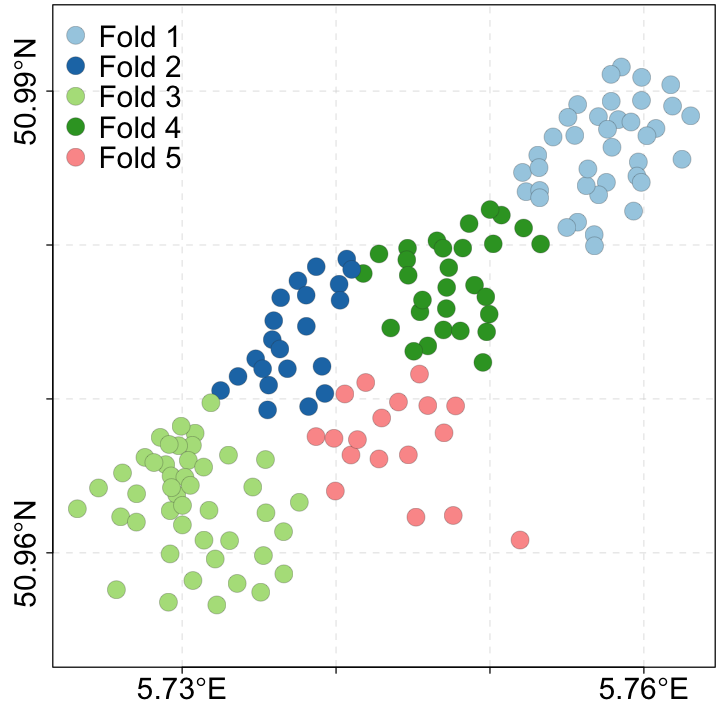

In [7]:
fold <- 5
col <- RColorBrewer::brewer.pal(fold, "Paired")
idx <- rep_len(" ", nrow(meuse.sf))
cols <- sapply(1:fold, function(i){
  rep_len(col[i], length.out = length(outer.rin$test.inds[[i]]))
}) %>% unlist()
idx[unlist(outer.rin$test.inds)] <- cols

coords <- st_coordinates(meuse.sf) %>% as.data.frame()

library(repr)
# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)

par(mar=c(2,2,0,0)+0.2, tcl=-0.25)
plot(coords$X, coords$Y, type = 'n', xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
ext <- par('usr')
segments(x0=axTicks(1), y0=ext[2],
         x1=axTicks(1), y1=ext[4], lwd=0.5,lty=2,col='lightgrey')
segments(x0=ext[1], y0=axTicks(2),
         x1=ext[3], y1=axTicks(2), lwd=0.5,lty=2,col='lightgrey')
points(coords$X, coords$Y, 
       pch = 21, bg = idx, col = 'grey20', lwd=0.2, cex=2)
xlabs <- sapply(axTicks(1), function(x) as.expression(substitute(l*degree*"E",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = c(xlabs[1], rep('', length(xlabs)-2), xlabs[length(xlabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
axis(2, axTicks(2), labels = c(ylabs[1], rep('', length(ylabs)-2), ylabs[length(ylabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
legend("topleft", legend=paste0("Fold ", 1:5), 
       pch = 21, pt.bg = col, 
       col = 'grey20', cex = 1.5, bty = 'n', pt.cex =2, pt.lwd = 0.2)

#### Spatial CV: evaluating

For every outer fold, hyperparameters are tuned on the inner folds. The best hyperparameter setting is used to train on the corresponding outer fold.

Note: the following code may take a long time.

In [7]:
library(glmnet)
library(FNN)
library(ranger)

res <- lapply(1:outer_n, function(oi) {
  res.rmse <- NULL
  params <- 2:7
  # inner folds eval
  for(i in 1:length(params)){
    cv.res <- lapply(1:inner_n, function(cvi) {
      hold_eval(param = params[i],
                train.id = inner[[oi]]$train.inds[[cvi]], test.id = inner[[oi]]$test.inds[[cvi]], 
                target.var = "zinc", data.sf = meuse.sf, spatial = F)
    })
    res.rmse[i] <- aggregate(unlist(cv.res), by = list(rep(1:4, times = inner_n)), mean)[3, 2]
  }
  print(paste0("Done: inner tuning of outer fold ", oi))
  flush.console()
  # outer eval
  rmse.outer <- unlist(hold_eval(param = params[which.min(res.rmse)], 
                          train.id = outer.rin$train.inds[[oi]], test.id = outer.rin$test.inds[[oi]], 
                          target.var = "zinc", data.sf = meuse.sf, spatial = F))
  print(paste0("Done: outer fold ", oi, ". RMSE: ", rmse.outer[3]))
  flush.console()
  return(rmse.outer)
})
# Average results from outer folds
avg.nested <- aggregate(unlist(res), by = list(rep(1:4, times = outer_n)), mean)[3, 2]


[1] "Done: inner tuning of outer fold 1"
[1] "Done: outer fold 1. RMSE: 265.470910417285"
[1] "Done: inner tuning of outer fold 2"
[1] "Done: outer fold 2. RMSE: 229.241298980632"
[1] "Done: inner tuning of outer fold 3"
[1] "Done: outer fold 3. RMSE: 151.723484641742"
[1] "Done: inner tuning of outer fold 4"
[1] "Done: outer fold 4. RMSE: 268.663918865291"
[1] "Done: inner tuning of outer fold 5"
[1] "Done: outer fold 5. RMSE: 172.751424756224"


The estimated generalization RMSE is:

In [8]:
avg.nested

[1] 217.5702

-----

#### Final lag model: tuning

This step is to tune the hyperparameter (`mtry` in random forest) for our final model. 5-fold spatial CV is still used here.

Note: the following code may take a long time.

In [9]:
# Final model: tuning ----
# 5-fold spatial CV
set.seed(134)
rdesc <- makeResampleDesc(cvmethod, iters = 5)
spatial.task <- makeRegrTask(data = st_drop_geometry(meuse.sf), target = "zinc", 
                             coordinates = as.data.frame(st_coordinates(meuse.sf)))
tune.rin <- makeResampleInstance(rdesc, task = spatial.task)
rm(rdesc, spatial.task)

params <- 2:7
tune.res <- sapply(1:length(params), function(i) {
  cv.res <- lapply(1:5, function(cvi) {
    hold_eval(param = params[i],
              train.id = tune.rin$train.inds[[cvi]], test.id = tune.rin$test.inds[[cvi]], 
              target.var = "zinc", data.sf = meuse.sf, spatial = F)
  })
  aggregate(unlist(cv.res), by = list(rep(1:4, times = 5)), mean)[3, 2]
})

The best 'mtry' value is:

In [10]:
params[which.min(tune.res)]

[1] 4

#### Final lag model: training

Use the best hyperparameter found in last step.

In [11]:
set.seed(234)
final.model <- ranger::ranger(x = dplyr::select(st_drop_geometry(meuse.sf), -c("zinc")), 
                              y = meuse.sf$zinc, 
                              mtry = params[which.min(tune.res)], num.trees = 200, num.threads = 2)

pred <- predict(final.model, dplyr::select(st_drop_geometry(meuse.sf), -c("zinc"))) %>% ranger::predictions()
rmse.train <- ModelMetrics::rmse(actual = meuse.sf$zinc, predicted = pred)


Training RMSE of the final model is: .     

In [12]:
rmse.train

[1] 86.57777

The following step evaluates the global spatial autocorrelation (Moran's I) of the residuals. Spatial weight matrix is set to 5 nearest neighbors.

In [13]:
# Final model: Moran ----
library(spdep)
# Creating neighboring list
nb <- FNN::get.knn(as.matrix(st_coordinates(meuse.sf)), 5)$nn.index %>% 
  apply(1, list) %>% unlist(recursive = F)
attr(nb, "class") <- "nb"
# Moran's I (1000 Monte-Carlo simulation)
mc <- moran.mc(meuse.sf$zinc - pred, nb2listw(nb), nsim = 999)

Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



In [14]:
mc


	Monte-Carlo simulation of Moran I

data:  meuse.sf$zinc - pred 
weights: nb2listw(nb)  
number of simulations + 1: 1000 

statistic = 0.18497, observed rank = 1000, p-value = 0.001
alternative hypothesis: greater


-----

The distribution of residuals:

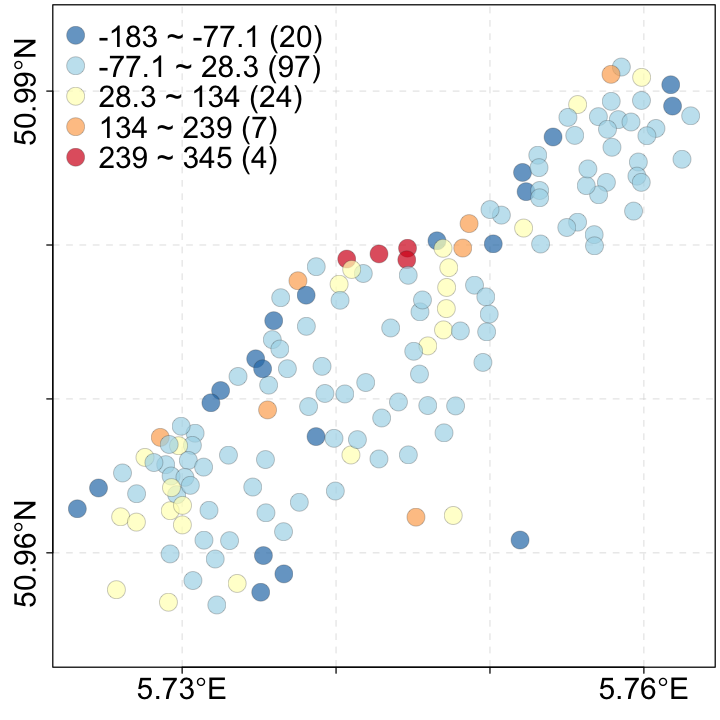

In [15]:
resi <- meuse.sf$zinc - pred
coords <- st_coordinates(meuse.sf) %>% as.data.frame()
ngroup <- 5
# intervals <- cut(resi, quantile(resi, seq(0, 1, 1/ngroup))) # quantile break
intervals <- cut(resi, ngroup) # equal interval break
colors <- RColorBrewer::brewer.pal(ngroup, "RdYlBu") %>% scales::alpha(0.7) %>% rev()
legend.lab <- strsplit(levels(intervals), split = "[,(\\]]", perl = T) %>% 
  lapply(function(x) {paste(x[-1], collapse = ' ~ ')}) %>% unlist()
legend.lab <- paste(legend.lab, "(") %>% paste0(table(intervals), ")")

# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)
par(mar=c(2,2,0,0)+0.2, tcl=-0.25)
plot(coords$X, coords$Y, type = 'n', xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
ext <- par('usr')
segments(x0=axTicks(1), y0=ext[2],
         x1=axTicks(1), y1=ext[4], lwd=0.5,lty=2,col='lightgrey')
segments(x0=ext[1], y0=axTicks(2),
         x1=ext[3], y1=axTicks(2), lwd=0.5,lty=2,col='lightgrey')
points(coords$X, coords$Y, 
     pch = 21, bg = colors[intervals], col = 'grey20', lwd=0.2, cex = 2)
xlabs <- sapply(axTicks(1), function(x) as.expression(substitute(l*degree*"E",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = c(xlabs[1], rep('', length(xlabs)-2), xlabs[length(xlabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
axis(2, axTicks(2), labels = c(ylabs[1], rep('', length(ylabs)-2), ylabs[length(ylabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
legend("topleft", legend = legend.lab, 
       pch = 21, pt.bg = colors, 
       col = 'grey20', cex = 1.5, bty = 'n', pt.cex =2, pt.lwd = 0.2)

The distribution of predicted values:

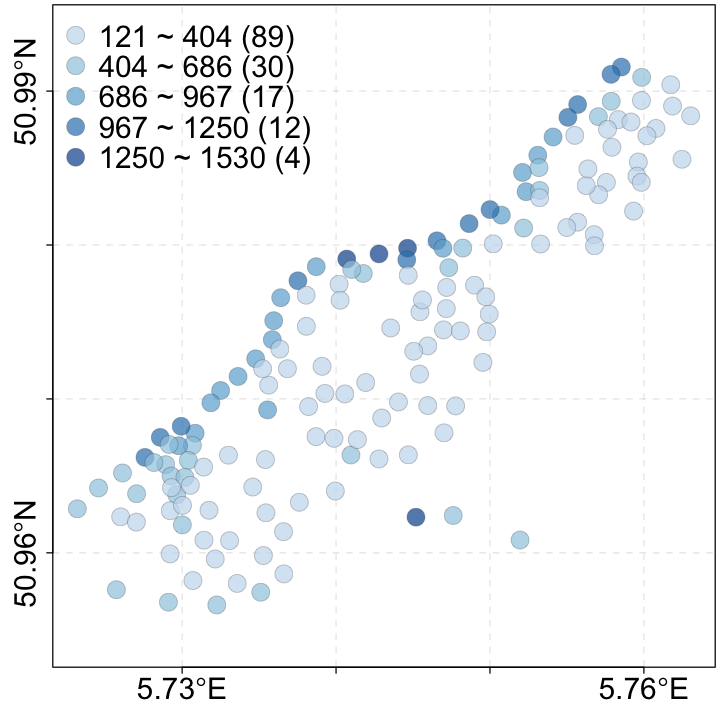

In [16]:
coords <- st_coordinates(meuse.sf) %>% as.data.frame()
ngroup <- 5
intervals <- cut(pred, ngroup) # equal interval break
colors <- RColorBrewer::brewer.pal(ngroup+1, "Blues") %>% 
  scales::alpha(0.7) %>% "["(-1)
legend.lab <- strsplit(levels(intervals), split = "[\\[,(\\]]", perl = T) %>% 
  lapply(function(x) {paste(as.numeric(x[-1]), collapse = ' ~ ')}) %>% unlist()
legend.lab <- paste(legend.lab, "(") %>% paste0(table(intervals), ")")

# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)
par(mar=c(2,2,0,0)+0.2, tcl=-0.25)
plot(coords$X, coords$Y, type = 'n', xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
ext <- par('usr')
segments(x0=axTicks(1), y0=ext[2],
         x1=axTicks(1), y1=ext[4], lwd=0.5,lty=2,col='lightgrey')
segments(x0=ext[1], y0=axTicks(2),
         x1=ext[3], y1=axTicks(2), lwd=0.5,lty=2,col='lightgrey')
points(coords$X, coords$Y, 
       pch = 21, bg = colors[intervals], col = 'grey20', lwd=0.2, cex=2)
xlabs <- sapply(axTicks(1), function(x) as.expression(substitute(l*degree*"E",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = c(xlabs[1], rep('', length(xlabs)-2), xlabs[length(xlabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
axis(2, axTicks(2), labels = c(ylabs[1], rep('', length(ylabs)-2), ylabs[length(ylabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
legend("topleft", legend = legend.lab, 
       pch = 21, pt.bg = colors, 
       col = 'grey20', cex = 1.5, bty = 'n', pt.cex =2, pt.lwd = 0.2)

LISA clusters:

Note: The local Moran is calculated from Python library 'PySAL'. Because the PySAL library has dependencies on other spatial packages, the following code may not work on different environments. One possible solution for MacOS users it to change the environment variable *'DYLD_FALLBACK_LIBRARY_PATH'*.

In [17]:
# Please change the environment variable with caution!
oldenvir <- Sys.getenv("DYLD_FALLBACK_LIBRARY_PATH")
newenvir <- paste(oldenvir, ':/usr/local/lib:/usr/lib', sep='')
Sys.setenv(DYLD_FALLBACK_LIBRARY_PATH = newenvir)

In [18]:
# Calculate local Moran from Python library 'PySAL'
library(reticulate)
# Specify the Python location
use_python("/usr/local/bin/python3") 
wpysal <- import("libpysal.weights")
esda_Moran <- import("esda.moran")

Warning message:
“package ‘reticulate’ was built under R version 3.6.2”


In [ ]:
resi <- meuse.sf$zinc - pred

nb_pysal <- unclass(nb)
names(nb_pysal) <- seq_along(nb)
local.m.pysal <- esda_Moran$Moran_Local(resi, wpysal$W(dict(nb_pysal)))
local.m.i <- local.m.pysal$Is # Local Moran
local.p <- local.m.pysal$p_sim # Pseudo p-value from Monte-Carlo simulation
lag.resi <- multi_lag(resi, as.matrix(st_coordinates(meuse.sf)), 
                      k.vec = c(5)) %>% simplify2array()

# LISA cluster func (0.05 significance level)
lisa_lable <- function(x, lag, localP){
  mean.x <- mean(x)
  mean.lag <- mean(lag)
  labels <- sapply(seq_along(x), function(i){
    if((x[i] >= mean.x & lag[i] >= mean.lag) & (localP[i] <= 0.05))
      return(1) # high-high
    if((x[i] < mean.x & lag[i] < mean.lag) & (localP[i] <= 0.05))
      return(2) # low-low
    if((x[i] >= mean.x & lag[i] < mean.lag) & (localP[i] <= 0.05))
      return(3) # high-low
    if((x[i] < mean.x & lag[i] >= mean.lag) & (localP[i] <= 0.05))
      return(4) # low-high
    if(localP[i] > 0.05)
      return(5) # non-significant
  })
  return(factor(labels, levels = 1:5))
}
lab <- lisa_lable(resi, lag.resi, local.p) # LISA cluster labels


colors <- c("red", "blue", "lightpink", "skyblue2", "grey80") %>% 
  scales::alpha(0.7)
coords <- st_coordinates(meuse.sf) %>% as.data.frame()

# Set plot size
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 120)
par(mar=c(2,2,0,0)+0.2, tcl=-0.25)
plot(coords$X[which(lab == 5)], coords$Y[which(lab == 5)], 
     pch = 21, bg = colors[5], col = NULL, xlab = '', ylab = '', 
     xaxt='n', yaxt='n', asp=1)
grid(NULL, NULL)
xlabs <- sapply(axTicks(1), function(x) as.expression(substitute(l*degree*"E",list(l = x))))
ylabs <- sapply(axTicks(2), function(x) as.expression(substitute(l*degree*"N",list(l = x))))
axis(1, axTicks(1), labels = c(xlabs[1], rep('', length(xlabs)-2), xlabs[length(xlabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)
axis(2, axTicks(2), labels = c(ylabs[1], rep('', length(ylabs)-2), ylabs[length(ylabs)]), 
     mgp = c(2,0.5,0), cex.axis=1.5)

for(i in 1:4){
  points(coords$X[which(lab == i)], coords$Y[which(lab == i)], 
         pch = 21, bg = colors[lab][which(lab == i)], col = 'grey20', lwd = 0.2, cex=2)
}
legend("topleft", legend = paste(c("High-High (", "Low-Low (", "High-Low (", 
                                   "Low-High (", "Not Signif. ("), table(lab), ")", sep = ''), 
       pch = 21, pt.bg = colors, 
       col = 'white', cex = 1.5, bty = 'n', pt.cex =2, pt.lwd = 0.2)